# Import

In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import plotly
plotly.offline.init_notebook_mode()

In [2]:
from file_py.run_log_parser import RunLogParser
from file_py.csv_preprocessing_scaler import CsvPreprocessingScaler

from file_py.plots import Plots

from file_py.utils import MarkdownHelper

from file_py.attack_log_unification import AttackLogUnification
from file_py.stat_severity import StatSeverity
from file_py.attack_pattern_analyzer import AttackPatternAnalyzer
from file_py.signatures_patterns import SignaturePatterns

from file_py.signature_stats_calculator import SignatureStatsCalculator
from file_py.sigma_rule_analysis import SigmaRuleAnalysis

from file_py.plots_single_attack import PlotsSingleAttack

from file_py.correlation_matrix_plots import CorrelationMatrixPlots

from file_py.preprocessing_train_test_split import PreprocessingTrainTestSplit
from file_py.initial_training import InitialTraining
from file_py.hyperparameter_tuning import HyperparameterTuning
from file_py.advanced_models import AdvancedModels
from file_py.deep_learning_model import DeepLearningModel
from file_py.model_evaluator import ModelEvaluator

# CARICAMENTO FILE

Sostituire il percorso dei file attuali con il percorso dei file di interesse qui:

In [3]:
# FILE CONTENENTE I LOG
df = CsvPreprocessingScaler.read_csv_file("file_csv/Log_splunk_combined.csv")

# FILE CON LE DATE DI INIZIO E FINE DEGLI ATTACCHI
files = ['file_csv/attackLog_combined.csv']

# Preprocessing

In [4]:
df_raw = CsvPreprocessingScaler.RawPreprocessing(df)
df_Le = CsvPreprocessingScaler.LEPreprocessing(df)
df_OH = CsvPreprocessingScaler.OhePreprocessing(df)

In [5]:
df_std_LE = CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.LEPreprocessing(df))
df_std_OH = CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.OhePreprocessing(df))

# Test

In [6]:
attack_log_path = AttackLogUnification.attack_log_together( files,'file_csv/attackLog_combined.csv')

In [7]:
result_df_Le = RunLogParser.process_attacks(attack_log_path, CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.LEPreprocessing(df)))
result_df_OH = RunLogParser.process_attacks(attack_log_path, CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.OhePreprocessing(df)))
result_df_Raw = RunLogParser.process_attacks(attack_log_path, CsvPreprocessingScaler.RawPreprocessing(df))

# Graphic Analysis of Attacks

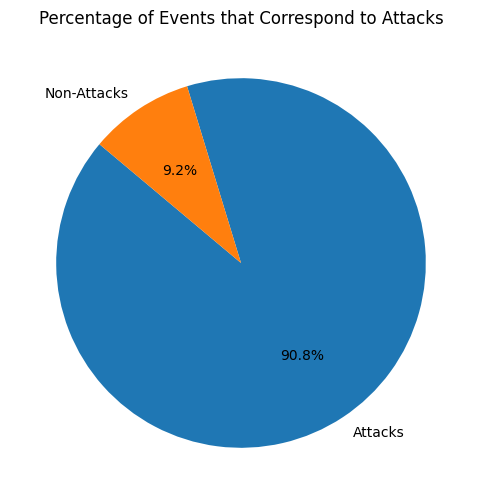

In [8]:
Plots.plot_cake_attack(result_df_Raw)

In [9]:
Plots.plot_top_10_signatures(result_df_Raw)

alt.VConcatChart(...)

Qui si può notare come generalmente le __regole scattate più volte__ sono anche quelle che hanno effettivamente __risposto a più attachi__ e che sono **scattate a vuoto più volte**.  

In [10]:
Plots.plot_precision_recall(result_df_Raw)

alt.VConcatChart(...)

Il *primo grafico* mostra la **precisione** di ciascuna regola, cioè la proporzione di **attivazioni corrette** rispetto al **totale delle sue attivazioni**.  
Una precisione più *alta* indica che la regola è *più accurata* nel rilevare veri attacchi.

Il *secondo grafico* mostra il **recall**, cioè la proporzione di **attacchi reali rilevati dalla regola** rispetto al **totale degli attacchi reali**.  
Un recall più *alto* indica che la regola è *più efficace* nel rilevare tutti gli attacchi possibili.

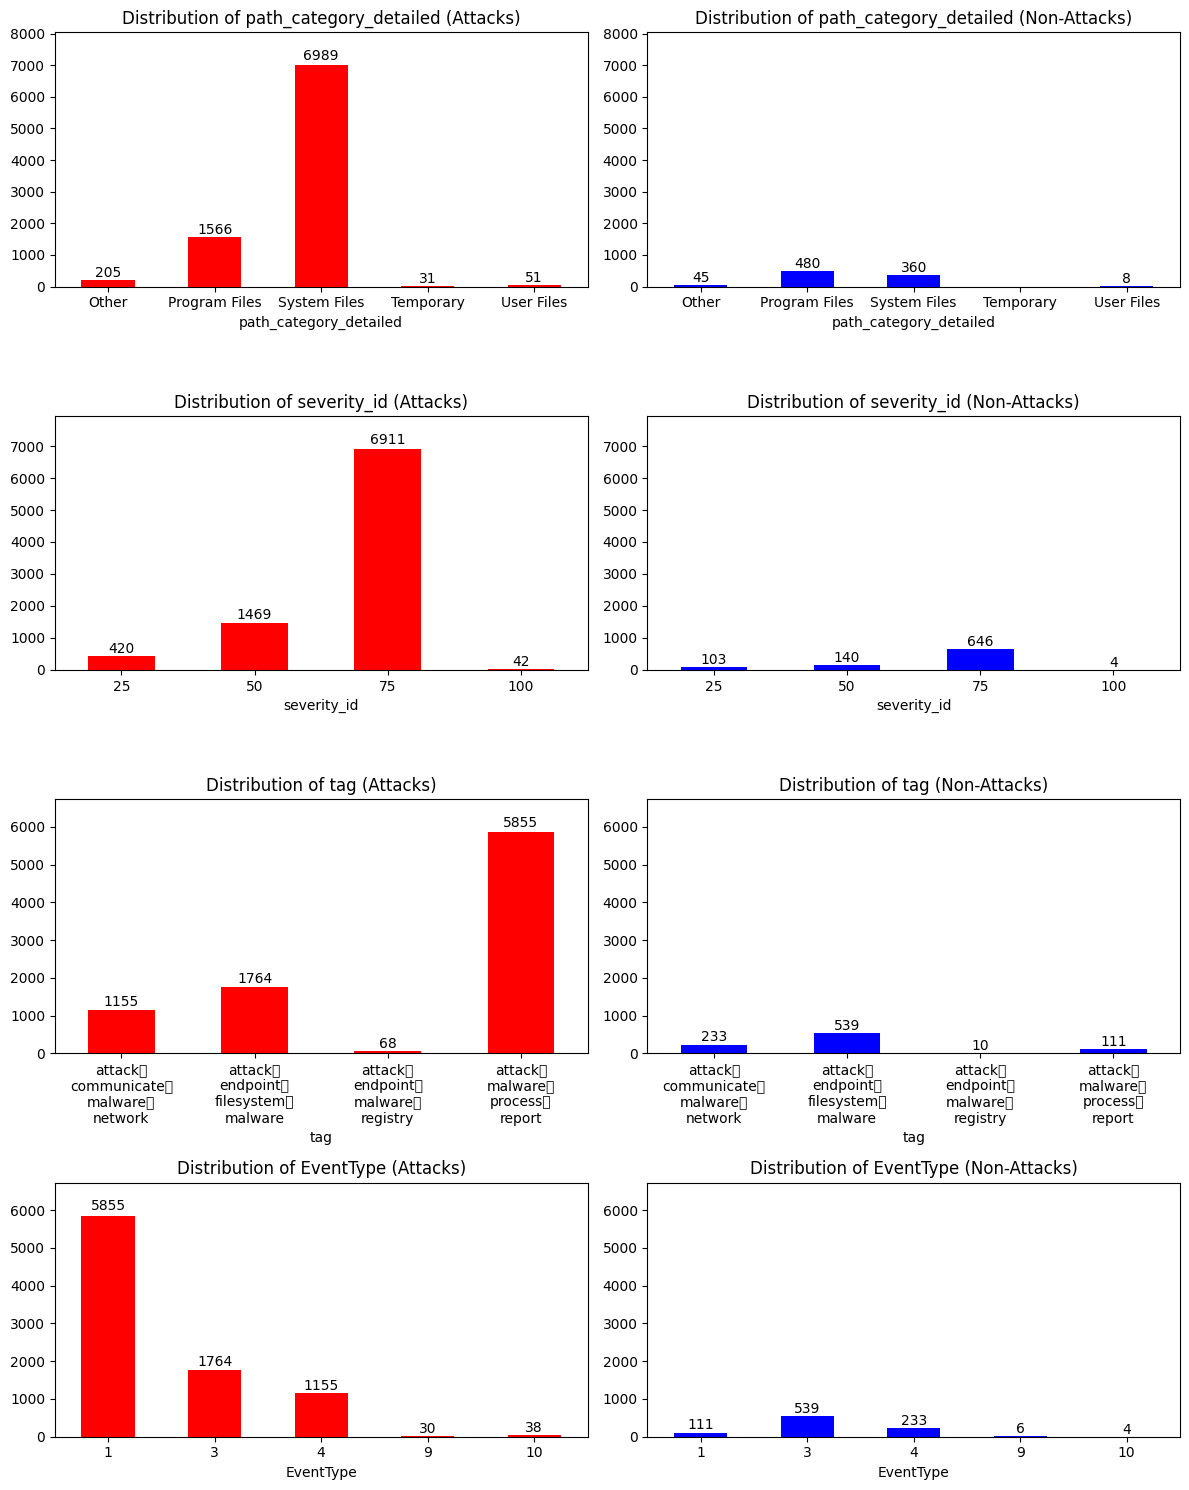

In [11]:
Plots.plot_distributions(result_df_Raw)

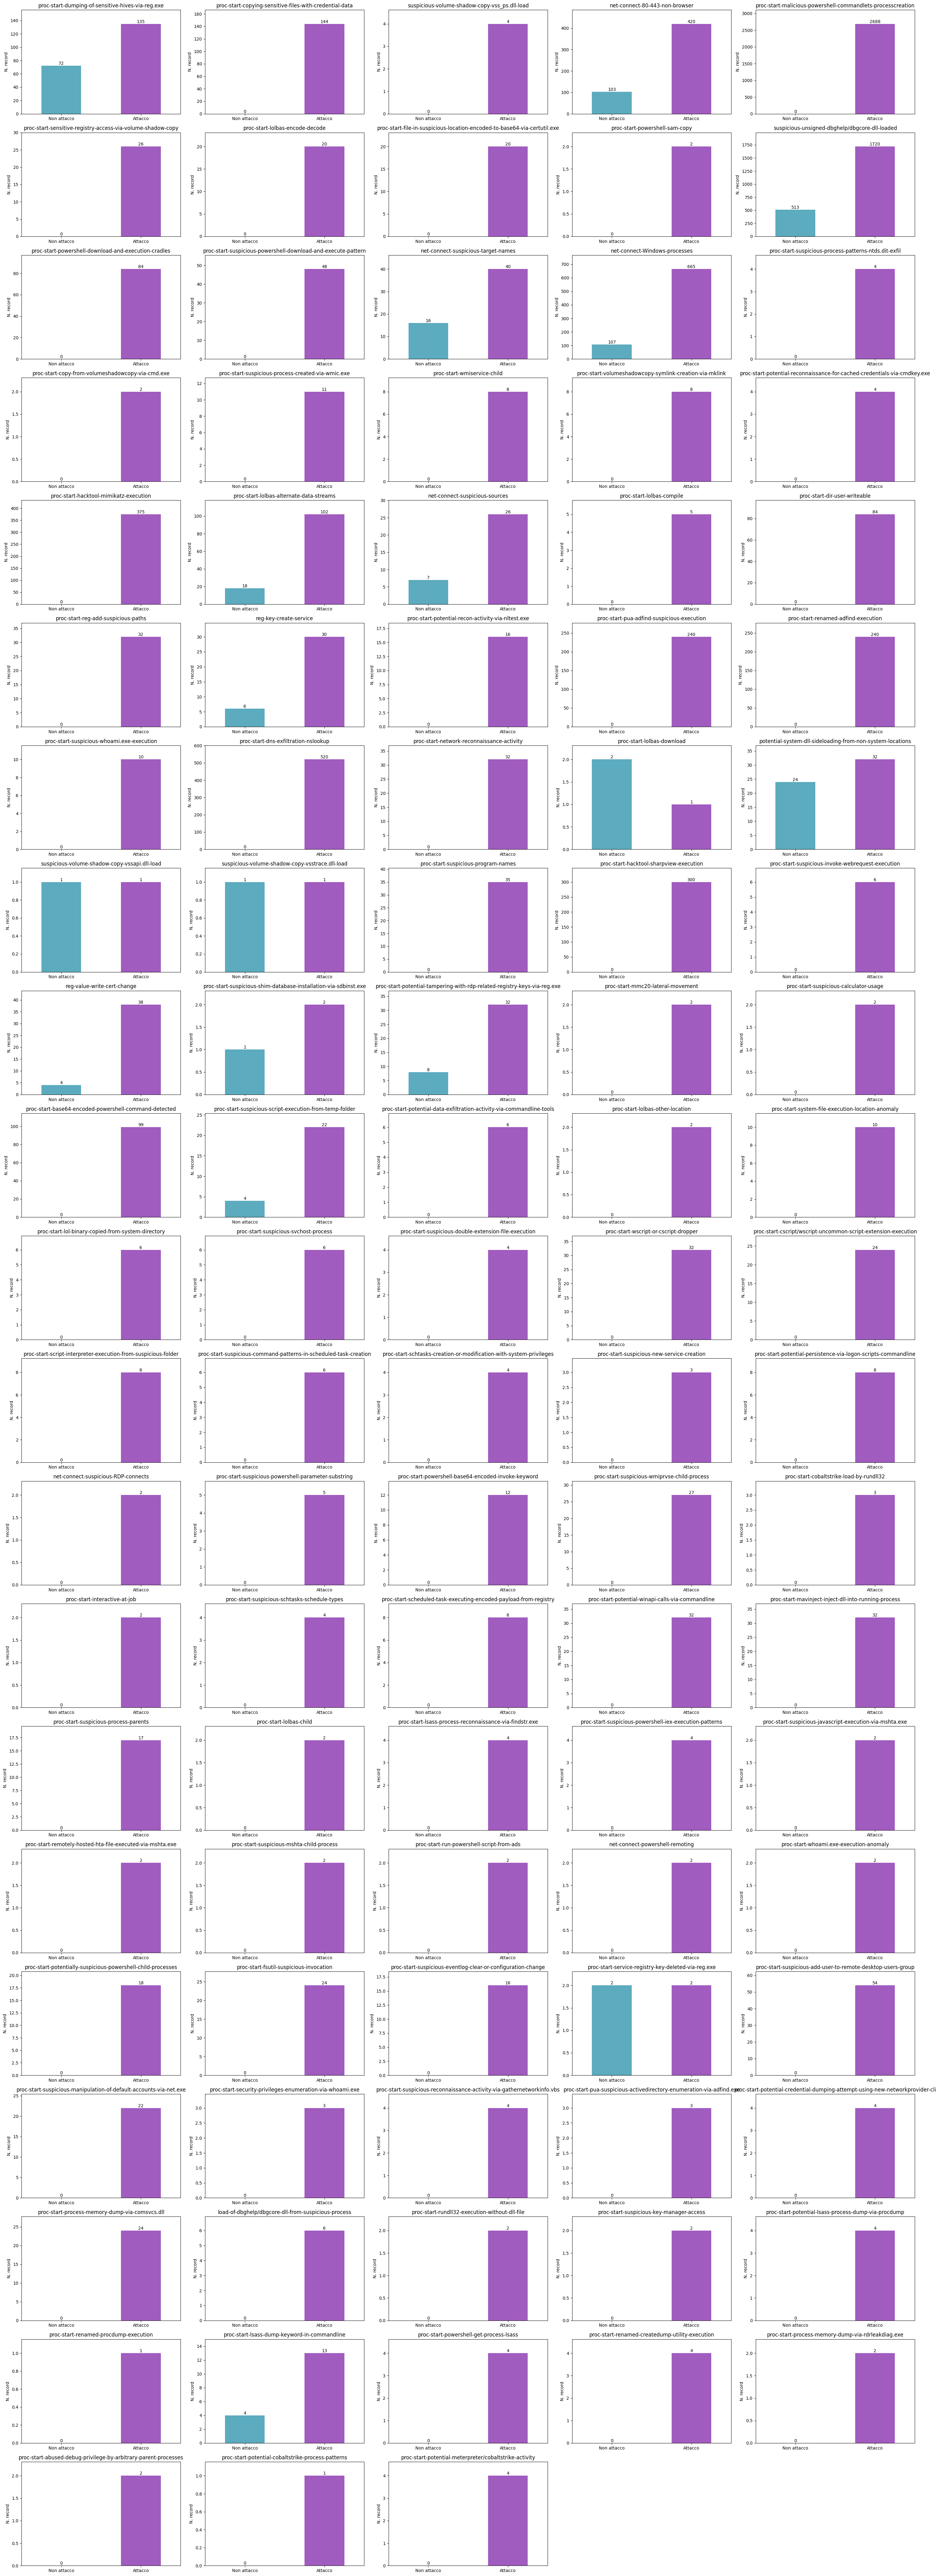

In [12]:
Plots.plot_value_counts_per_unique(result_df_Raw)

In [13]:
variables = MarkdownHelper.create_value_counts_variables(result_df_Raw)
MarkdownHelper.display_value_counts_text(variables)

<h5>Grazie a questo grafico invece possiamo giungere ad una serie di conclusioni.

Su **103** regole diverse:

- quelle scattate in risposta ad ALMENO un **attacco reale** sono **103**.
  Di queste:
  - **1** si sono attivate più volte per **non-attacchi** rispetto che per gli attacchi. (*regole generiche*)
  - **3** si sono attivate lo **stesso numero** di volte per attacchi e non-attacchi.
  - **99** si sono attivate più volte in risposta ad **attacchi** rispetto che a non-attacchi (*regole specifiche*).

- quelle scattate **senza rispondere mai ad attacchi** sono **0**.

  **Si tratta di**: []</h5>

# Analysis of Severity per Attacks

In [14]:
event_df = RunLogParser.create_event_df(attack_log_path, result_df_Raw)

Creazione del df **event_df** con le nuove colonne *severity_max, _min, _mean*

## Grafici

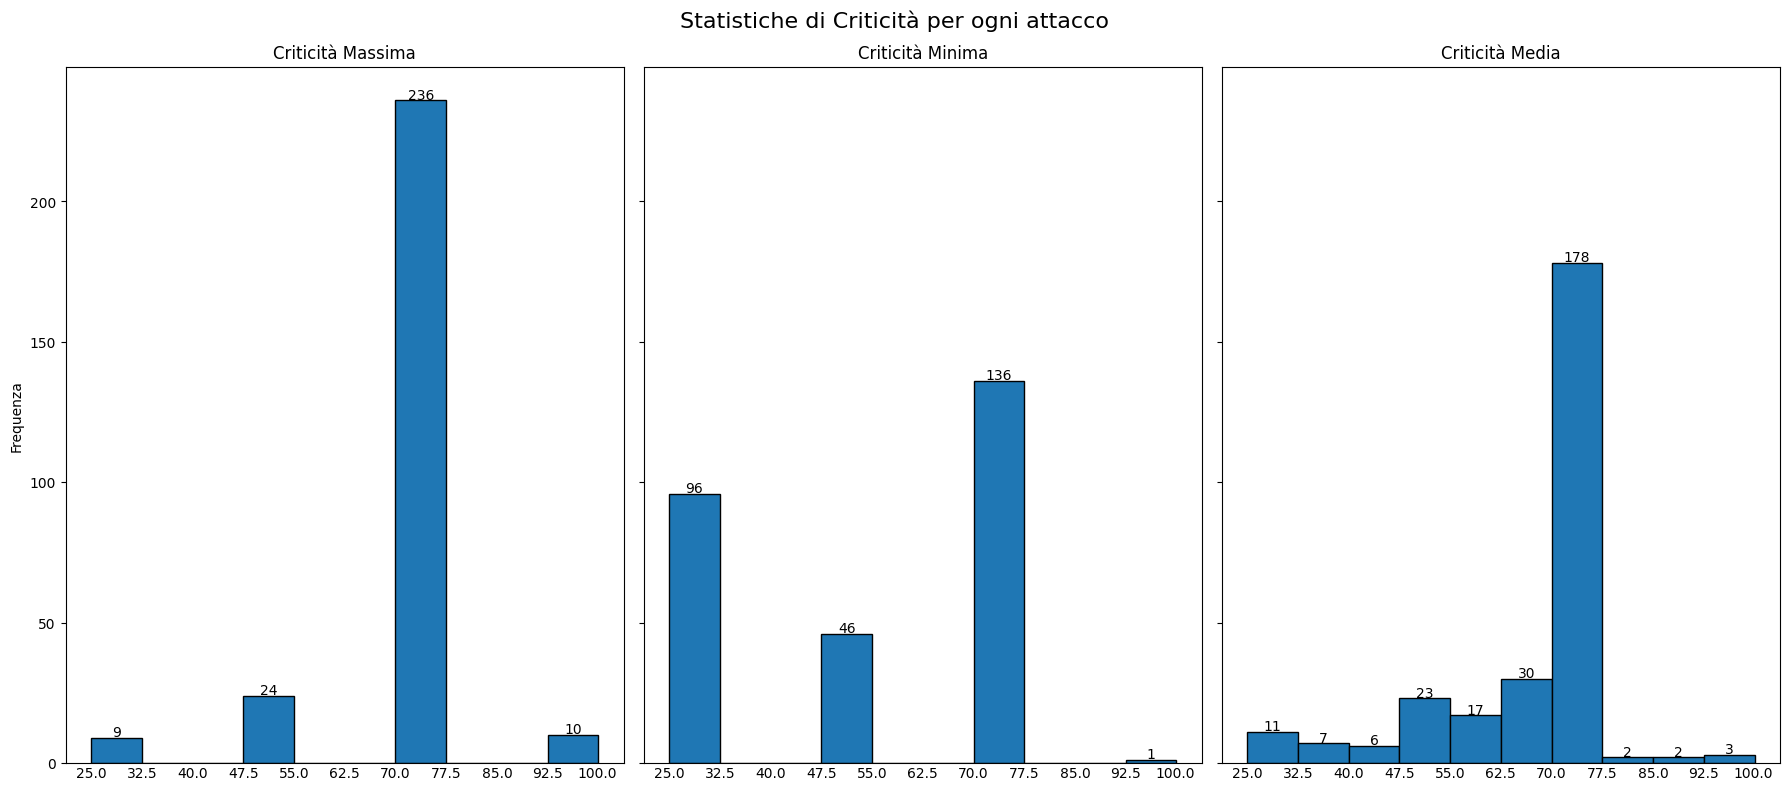

In [15]:
StatSeverity.plot_stat_severity(event_df)

In questo grafico vediamo, per **ciascun attacco** presente nel dataset, quali sono le loro **criticità** *massime, minime e medie*.

In [16]:
analyzer = AttackPatternAnalyzer(event_df)

In [17]:
# SCEGLIERE UN VALORE PER LA SEVERITY DELLE REGOLE DA CONSIDERARE
severity_value=73

# SCEGLIERE IL NUMERO DI ATTACCHI DA CONSIDERARE PRIMA DELLE REGOLE AVENTI LA SEVERITY SCELTA
num_attacks=10

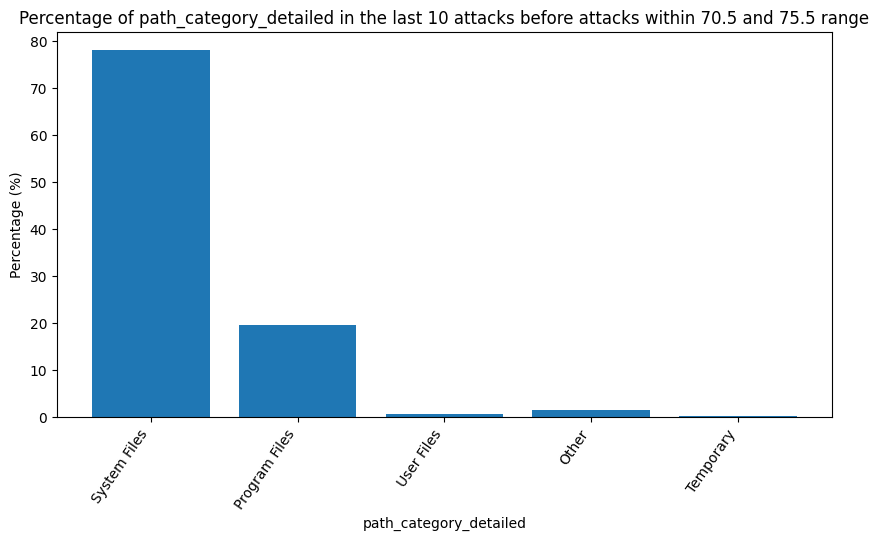

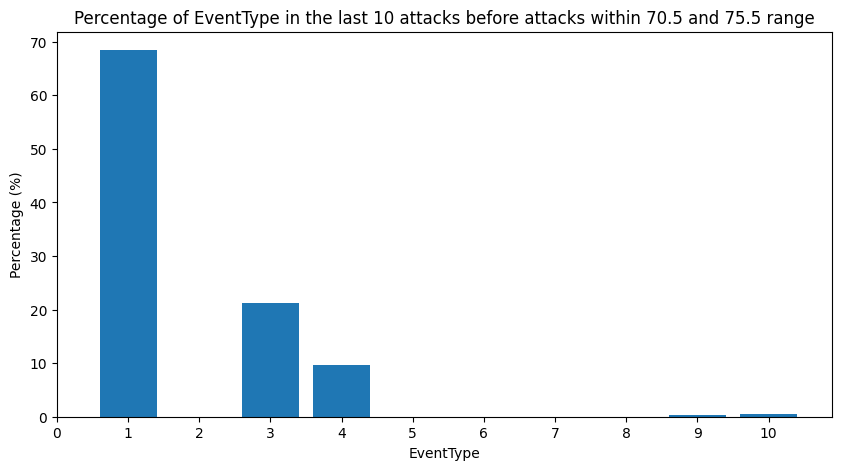

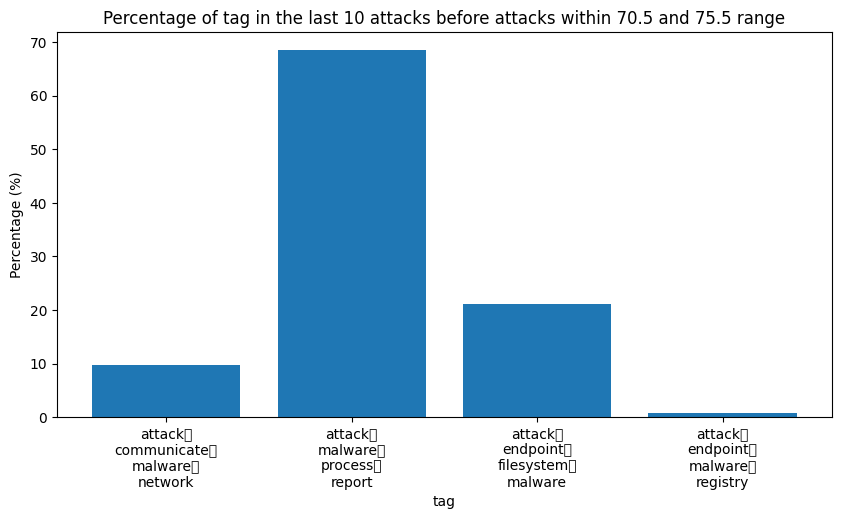

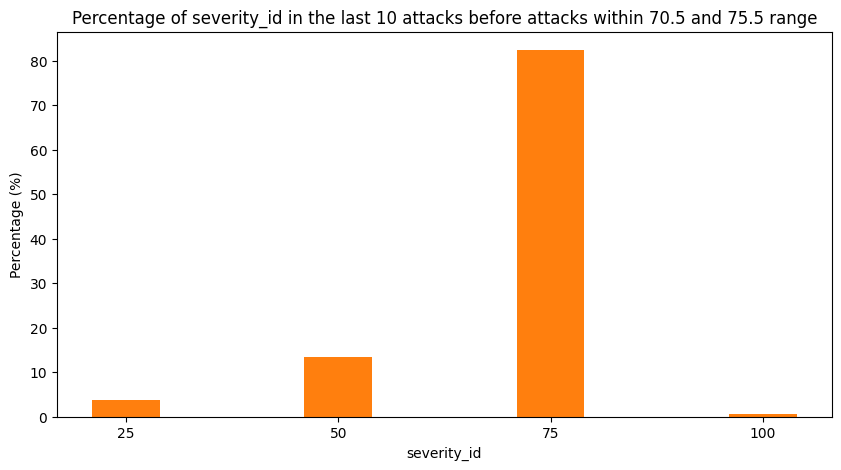

In [18]:
analyzer.pattern_before_attack(num_attacks=num_attacks, severity_value=severity_value)

In questi grafici prendiamo in considerazione gli **attacchi precedenti** a *tutti gli attacchi* che hanno una **certa criticità media** e *visualizziamo* tutti i valori di "**RuleAnnotation.mitre_attack.id**", "**signature**", "**EventType**", "**tag**", "**severity_id**" corrispondenti.

Per scegliere **quanti attacchi prima** *di quelli che ci interessano* vogliamo considerare basta modificare la variabile "**num_attacks**" e assegnarle il numero che vogliamo,  
mentre per scegliere il **valore della criticità media** che ci interessa si deve modificare la variabile "**severity_value**".  
Verranno presi in considerazione tutti gli attacchi con *criticità media compresa* tra **2.5 prima** e **2.5 dopo** del valore assegnato a "severity_value".

## Robustezza regole

In [19]:
signature_stats = SignatureStatsCalculator.create_signature_stats(event_df, result_df_Raw)
signature_stats

signature  Indice_Diff  \
0    proc-start-dumping-of-sensitive-hives-via-reg.exe     0.000421   
1    proc-start-copying-sensitive-files-with-creden...     0.001378   
2        suspicious-volume-shadow-copy-vss_ps.dll-load     0.000882   
3                       net-connect-80-443-non-browser     0.054409   
4    proc-start-malicious-powershell-commandlets-pr...     0.011123   
..                                                 ...          ...   
98     proc-start-renamed-createdump-utility-execution     0.000000   
99   proc-start-process-memory-dump-via-rdrleakdiag...     0.000000   
100  proc-start-abused-debug-privilege-by-arbitrary...     0.000052   
101  proc-start-potential-cobaltstrike-process-patt...     0.000034   
102  proc-start-potential-meterpreter/cobaltstrike-...     0.000072   

     Media_Differenza_Severity_min  Media_Differenza_Severity_mean  \
0                         0.000000                        0.068447   
1                         0.000000                        0.059737   
2                         0.000000                        0.005974   
3                        -9.537037                       -2.637203   
4                         0.000000                        0.325955   
..                             ...                             ...   
98                        0.000000                        0.000000   
99                        0.000000                        0.000000   
100                       0.000000                        0.000000   
101                       0.000000                        0.000000   
102                       0.000000                        0.000000   

     Media_Differenza_Severity_max  N_Max_Sev_Diff_15  N_Attacchi_Non_rilevati  
0                         0.000000                  0                        0  
1                         0.000000                  0                        0  
2                         0.000000                  0                        0  
3                         0.000000                  0                        9  
4                         0.179856                  1                        1  
..                             ...                ...                      ...  
98                        0.000000                  0                        0  
99                        0.000000                  0                        0  
100                       0.000000                  0                        0  
101                       0.000000                  0                        0  
102                       0.000000                  0                        0  

[103 rows x 7 columns]

**signature_stats** è un dataset in cui possiamo vedere per **ogni regola** se venisse **rimossa** *quali cambiamenti* di **severity** apporterebbe al *dataset dei log* e se ci dovessero essere degli **attacchi** che **non** vengono **rilevati**.

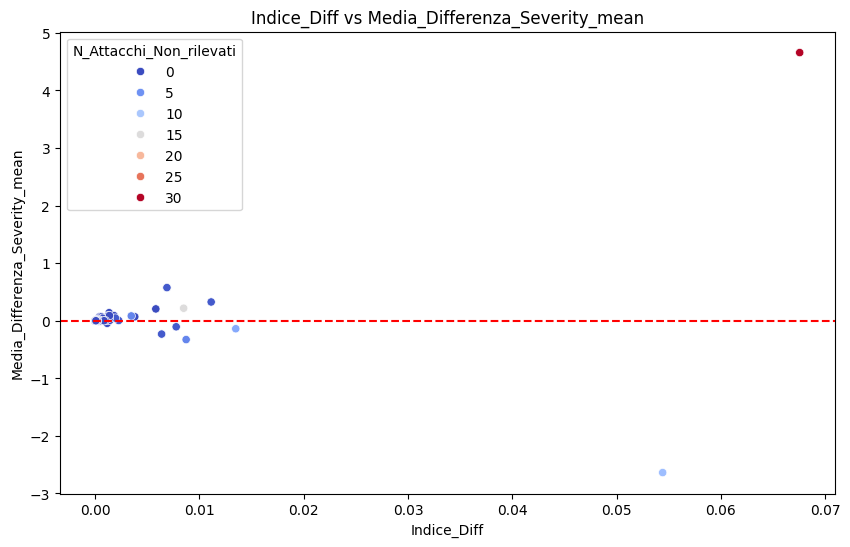

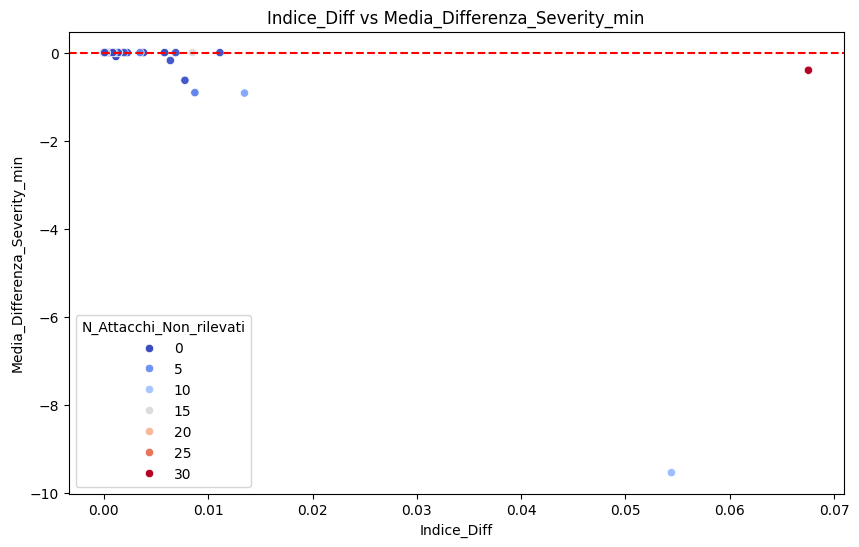

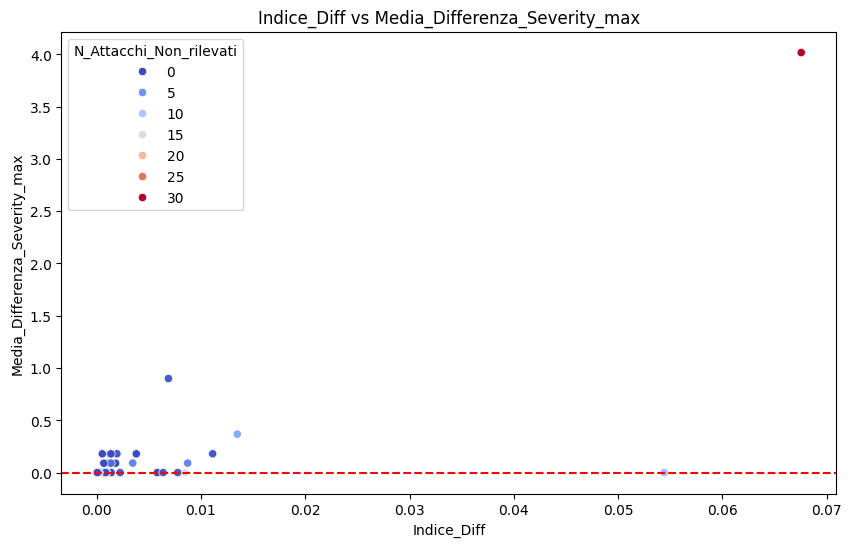

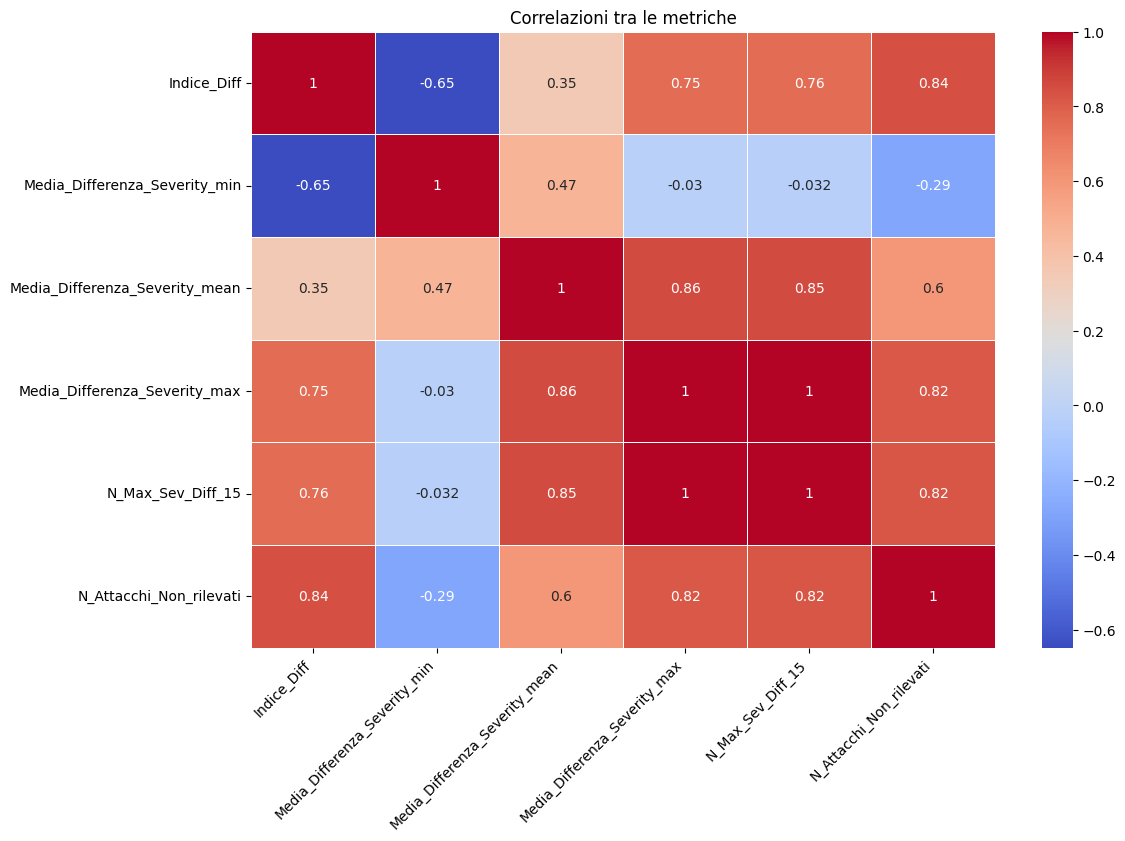

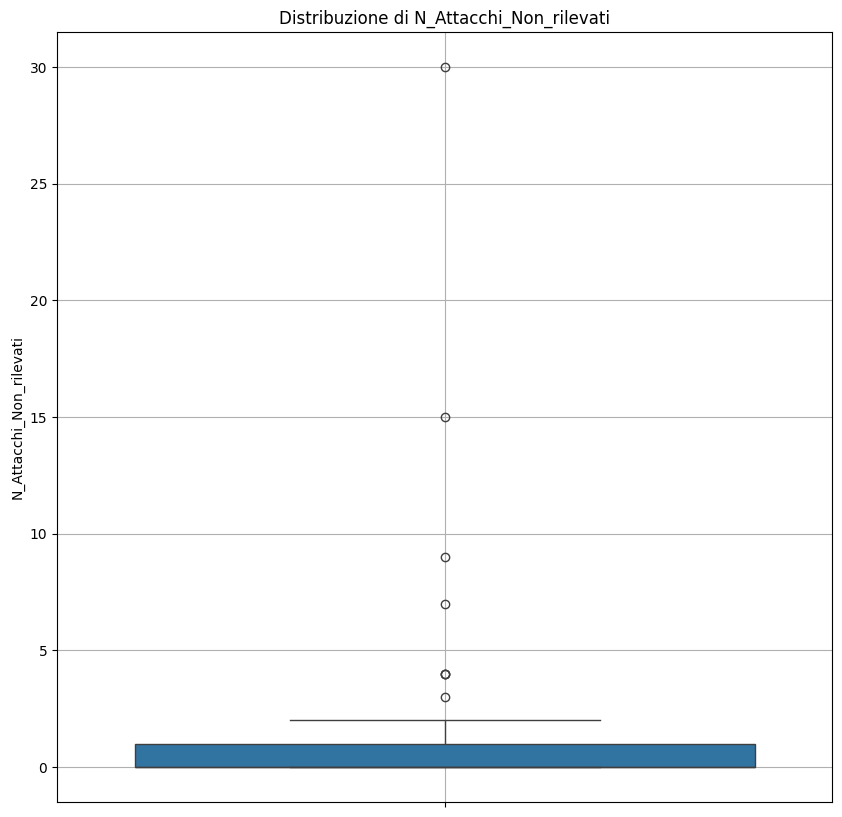

In [20]:
analysis = SigmaRuleAnalysis(signature_stats)
analysis.plots_sigma_rule_analysis()

# Graphic Analysis of Attacks for Chosen Rule

In [21]:
# SCEGLIERE LA REGOLA CHE SI VUOLE ANALIZZARE
regola_scelta = 'suspicious-unsigned-dbghelp/dbgcore-dll-loaded'

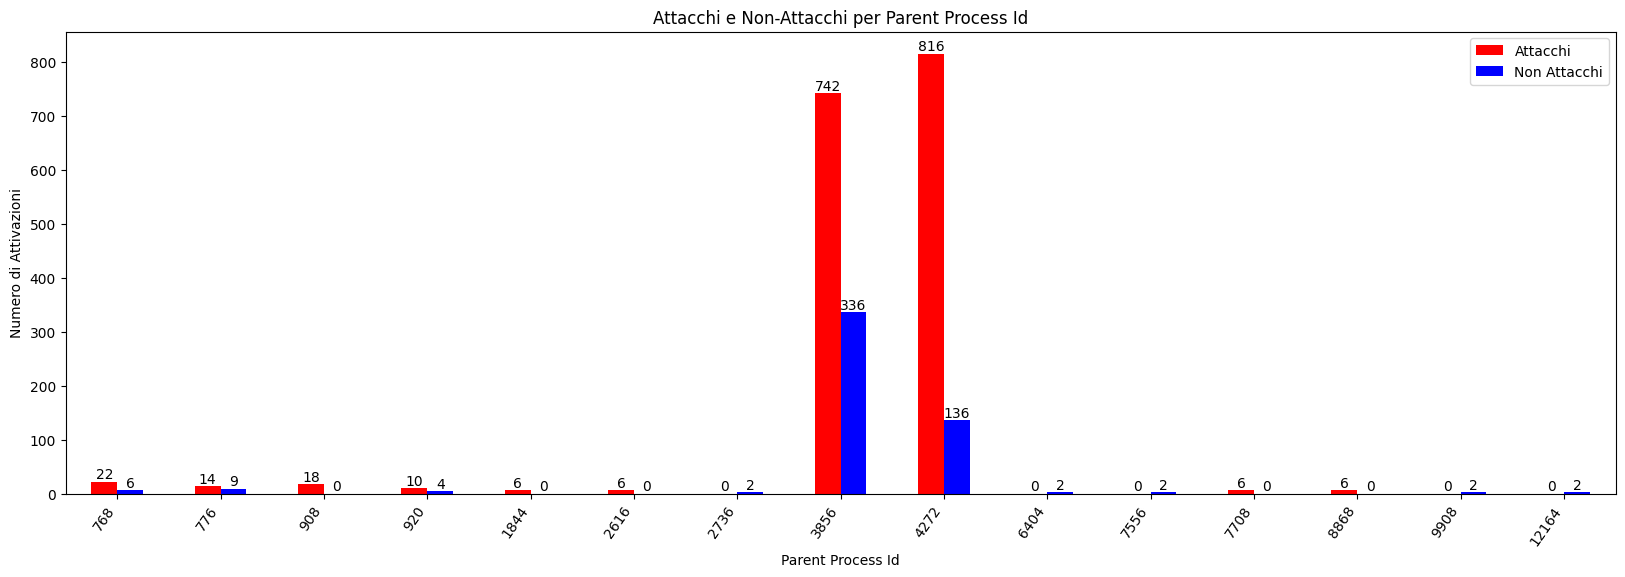

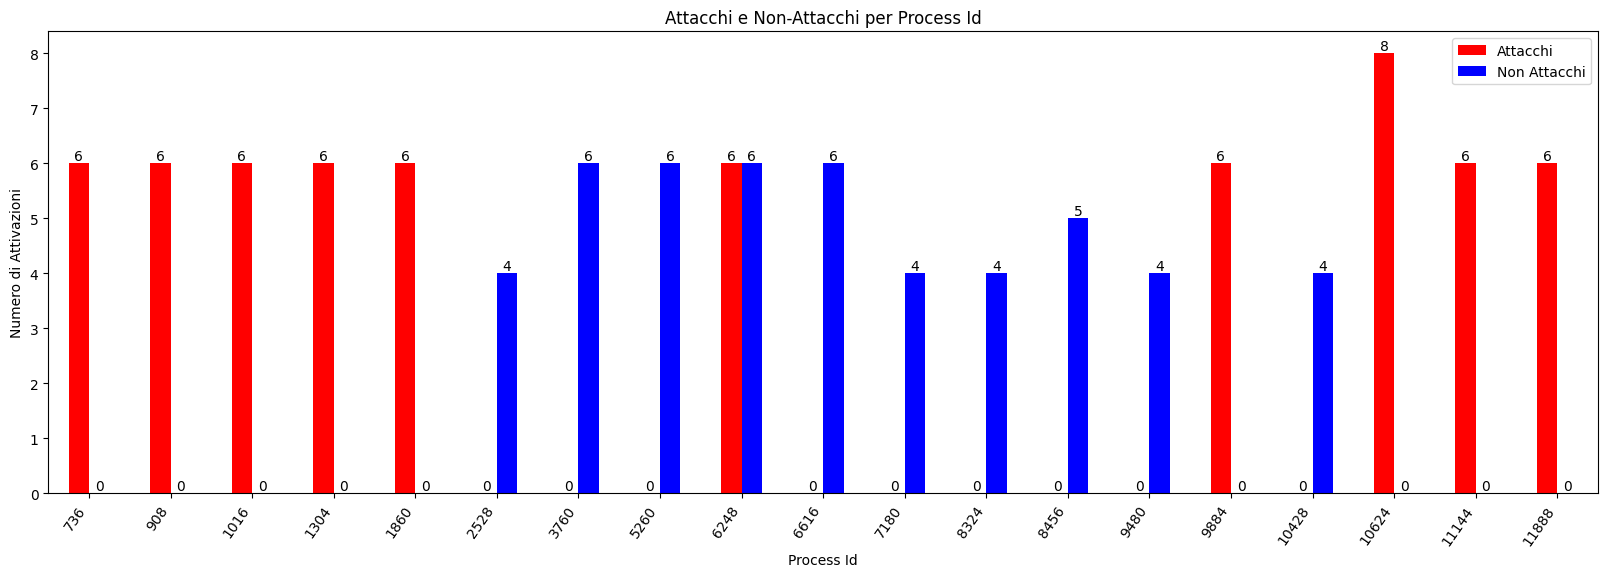

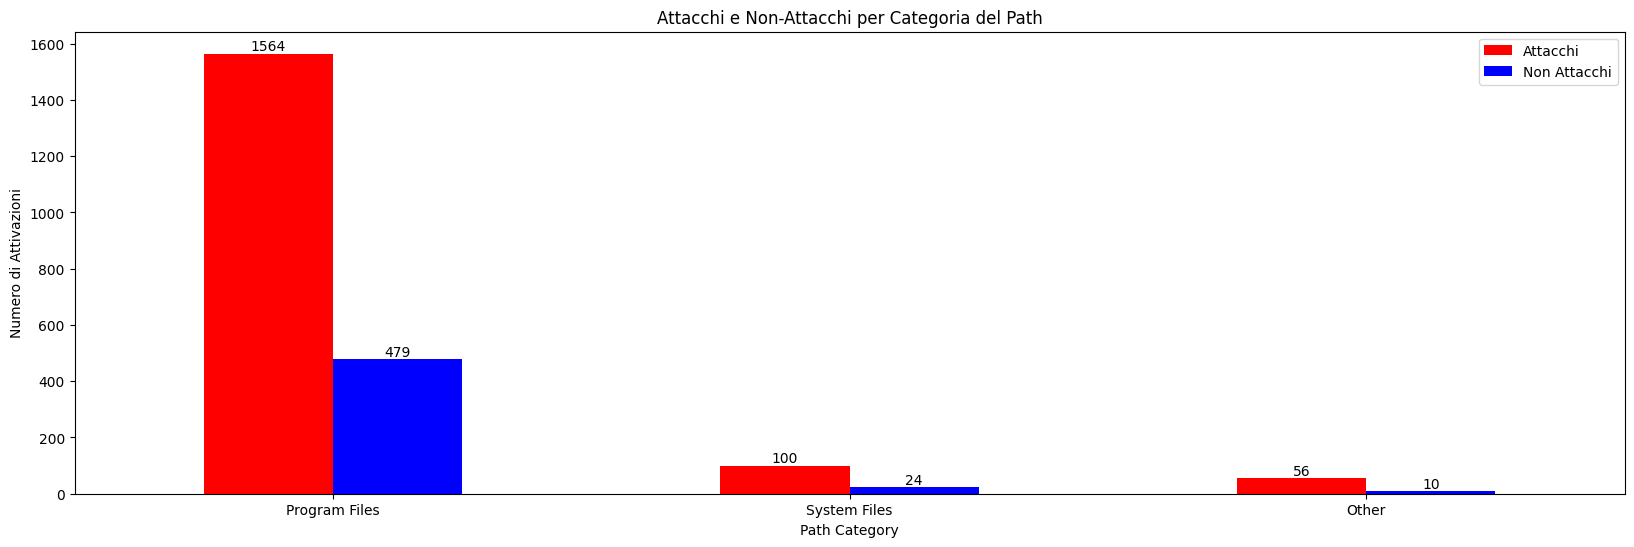

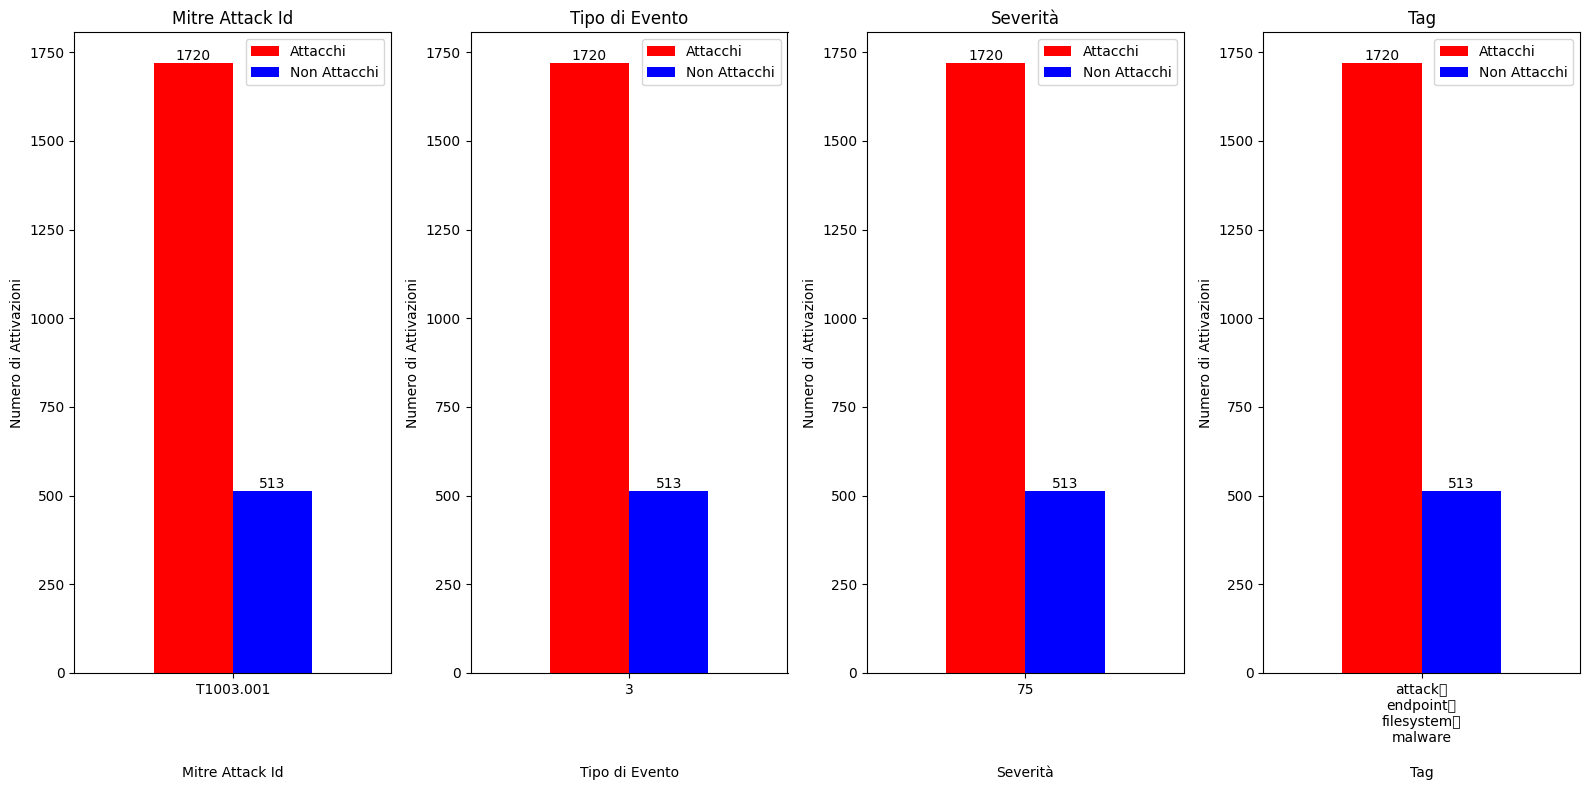

In [22]:
PlotsSingleAttack.analyze_rule_activations(result_df_Raw, regola_scelta)

In questi grafici in base alla **regola che si vuole analizzare** possiamo visualizzare:
- la **frequenza delle attivazioni** delle regole (attacchi e non attacchi) suddivise in intervalli di *5 minuti*;
- gli **attacchi e i non-attacchi** in base a:
    - *RuleAnnotation.mitre_attack.id*
    - *EventType*,
    - *severity*,
    - *tag*
    - *parent_process_id*,
    - *process_id*

In [23]:
# SCEGLIERE IL NUMERO DI EVENTI PRECEDENTI ALLA REGOLA CHE SI VOGLIONO ANALIZZARE
eventi_da_considerare = 5

alt.Chart(...)

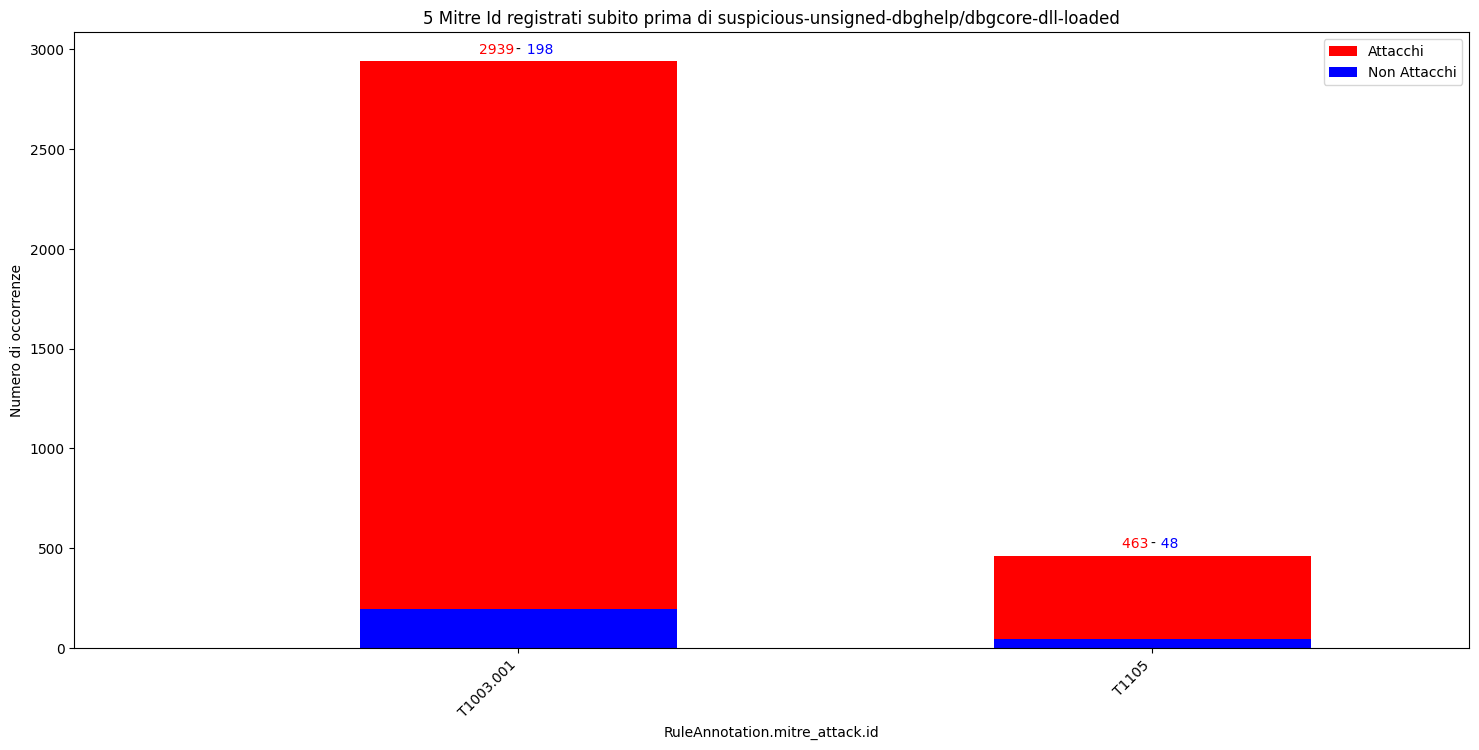

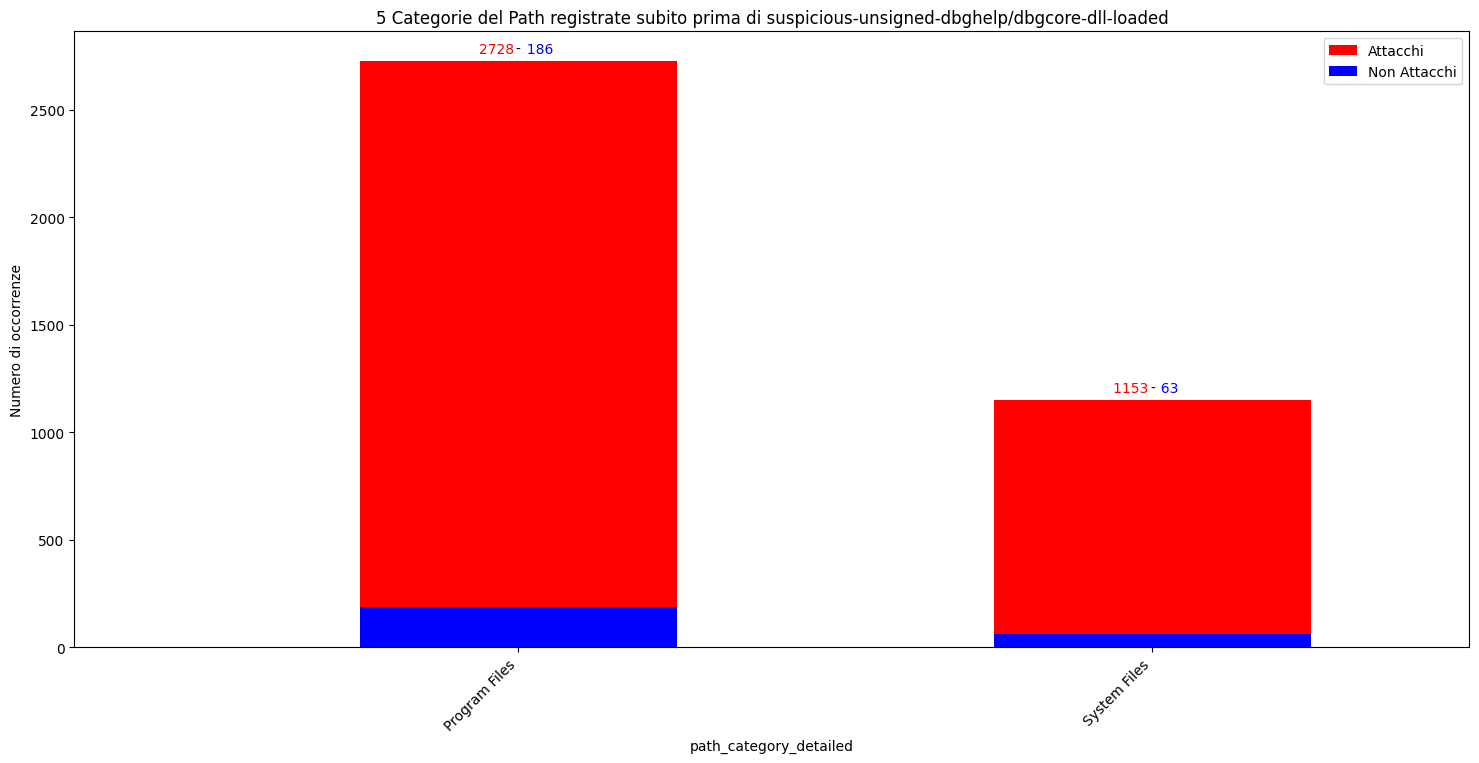

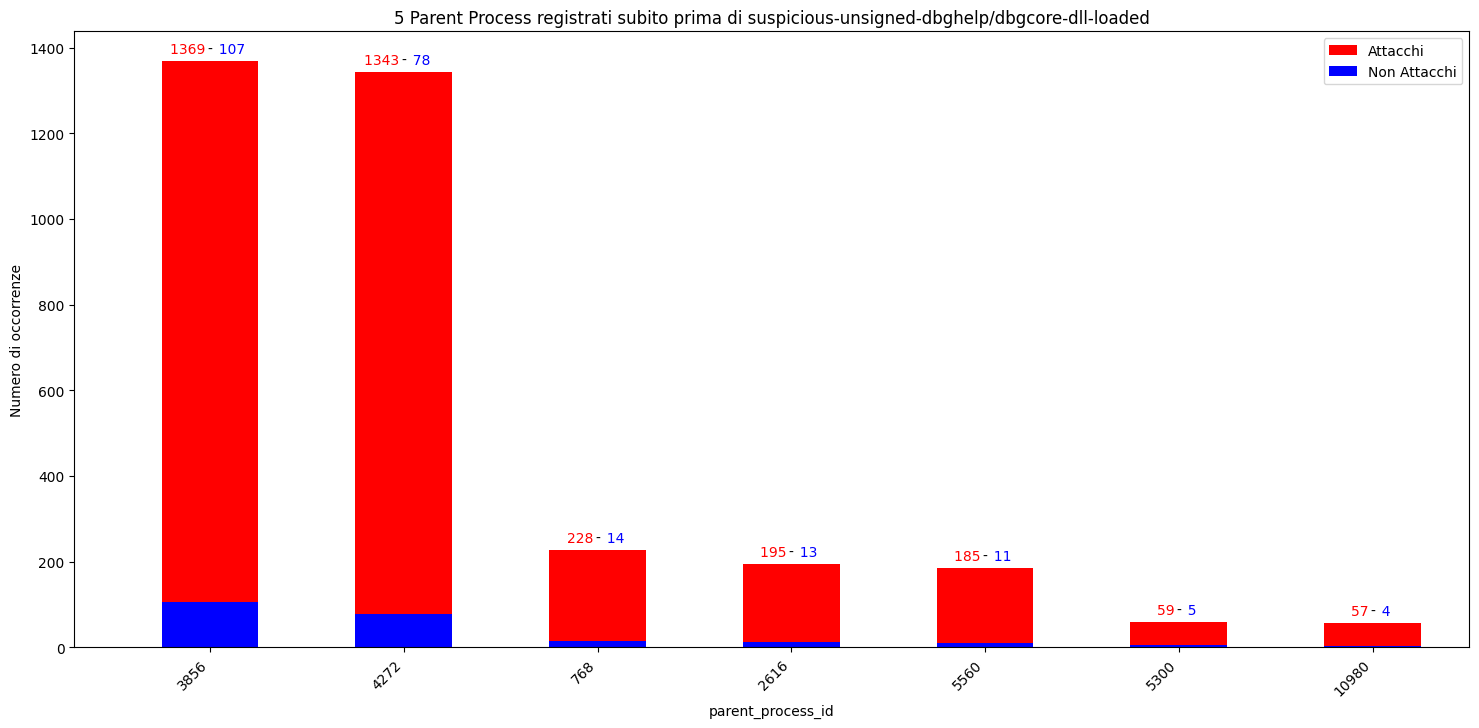

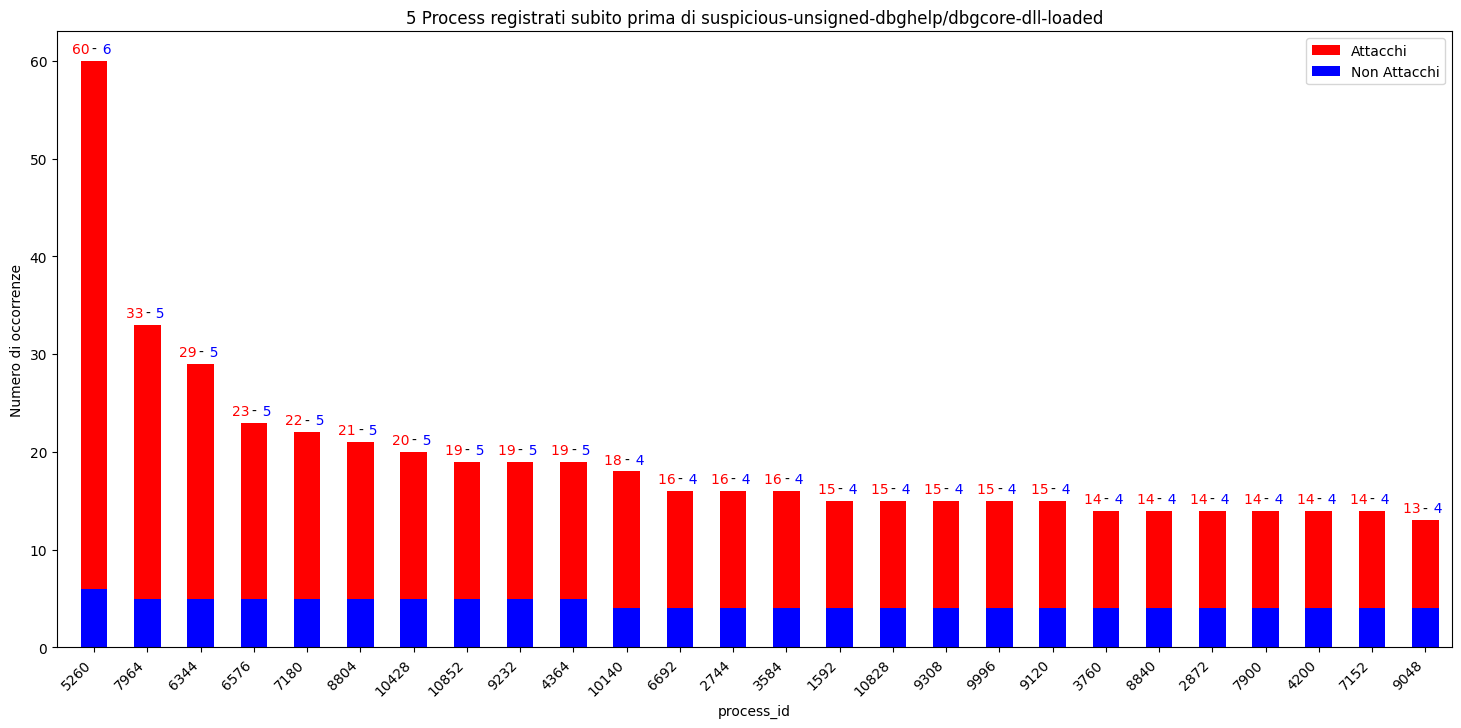

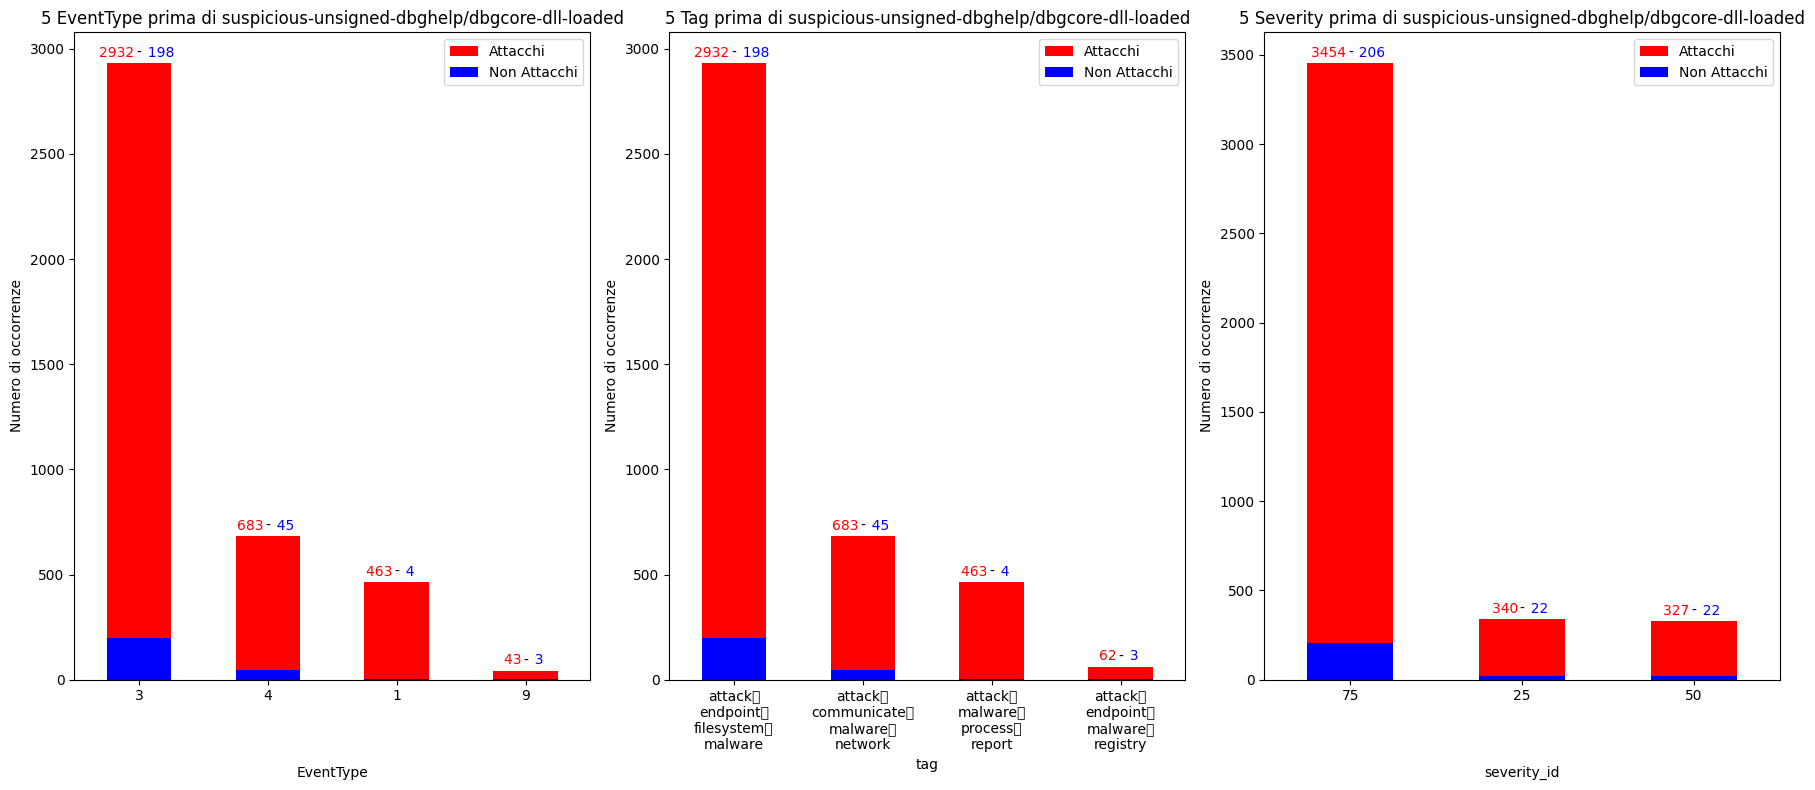

In [24]:
PlotsSingleAttack.patterns_before_activation(result_df_Raw, regola_scelta, eventi_da_considerare)

In questi grafici vediamo quali sono rispettivamente le *regole*, gli *attacchi*, gli *EventType*, i *tag*, i *parent_process*, i *process* e le *severity* degli eventi **subito prima** delle **prime attivazioni** della *regola scelta*.  
Il **numero di eventi da considerare** lo scegliamo affidando alla variabile *elementi_da_considerare* il numero che vogliamo.

Con "**prima attivazione di una regola**" si intende quando **almeno un elemento** delle colonne *signature, RuleAnnotation.mitre_attack.id, EventType, tag, severity_id, parent_process_id o process_id* (non sono considerate solo le colonne _time e corrisponde_ad_attacco) *di un evento* **differisce** da quello *precedente*.

# Patterns

In [25]:
signature_patterns = SignaturePatterns.recognize_signatures_patterns(result_df_Raw)
signature_patterns

Pattern: ('proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation'), Frequenza: 2646
Pattern: ('proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation'), Frequenza: 2604
Pattern: ('proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation', 'proc-start-malicious-powershell-commandlets-processcreation'), Frequenza: 2562
Pattern: ('proc-start-dns-exfiltration-nslookup', 'proc-start-dns-exfiltration-nslookup'), Frequenza: 466
Pattern: ('proc-start-dns-exfiltration-nslookup', 'proc-start-dns-exfiltration-nslookup', 'proc-start-dns-exfiltration-nslookup'), Frequenza: 426
Pattern: ('proc-start-dns-exfiltration-nslookup', 'proc-start-dns-exfiltration-nslookup', 'proc-star

In `signature_patterns` vediamo le **sequenze di 3, 4 o 5 regole** in ordine da quella più a quella meno frequente **ripetutesi più volte** durante i vari *attacchi* e che **non compaiono mai** tra le sequenze di *falsi attacchi*

## With specified severity value

In [26]:
result_pattern_inside_attack = analyzer.pattern_inside_attack(severity_value=severity_value)
result_pattern_inside_attack

MITRE ATT&CK IDs:
1-digit repetitions:

2-digits sequences:
  ('T1003.001', 'T1003.001'): 23
  ('T1055.001\r', 'T1055.001\r'): 3
  ('T1059', 'T1059.001'): 3
  ('T1003.002\r', 'T1003.002\r'): 2
  ('T1070.001\r', 'T1070.001\r'): 2
  ('T1003', 'T1036\r'): 2
  ('T1021.001\r', 'T1021.001\r'): 1
  ('T1053.005', 'T1053.005'): 1
  ('T1016\r', 'T1016\r'): 1
  ('T1059.001', 'T1059'): 1
  ('T1105', 'T1059.001'): 1
  ('T1070\r', 'T1070\r'): 1

3-digits sequences:
  ('T1482\r', 'T1482\r', 'T1482\r'): 21
  ('T1003.001', 'T1003.001', 'T1003.001'): 10
  ('T1049\r', 'T1049\r', 'T1049\r'): 4
  ('T1027\r', 'T1027\r', 'T1027\r'): 3
  ('T1106', 'T1003.001', 'T1003.001'): 3
  ('T1059', 'T1003.001', 'T1003.001'): 3
  ('T1112\r', 'T1112\r', 'T1562.001'): 2
  ('T1003.001', 'T1548', 'T1036'): 2
  ('T1003.001', 'T1003.001', 'T1059.001'): 2
  ('T1003.001', 'T1003.001', 'T1482\r'): 2
  ('T1059', 'T1059.001', 'T1105'): 2
  ('T1059', 'T1059.001', 'T1003.001'): 2
  ('T1003.001', 'T1003.001', 'T1059'): 2
  ('T1059.001

In `result_pattern_inside_attack` vediamo:
- '**1-digit repetitions**' che corrisponde alle **ripetizioni** di *mitre_attack.id* e *signature* in testa agli attacchi con un numero **massimo di 3** mitre o signature registrati;
- '**2-digits sequences**' che corrisponde alle **sequenze** di *mitre_attack.id* e *signature* in testa agli attacchi con un numero di mitre o signature **compreso tra 4 e 5**;
- '**3-digits sequences**' che corrisponde alle **sequenze** di *mitre_attack.id* e *signature* in testa agli attacchi con un numero di mitre o signature **maggiore di 5** (non compreso).

# Correlation Matrix

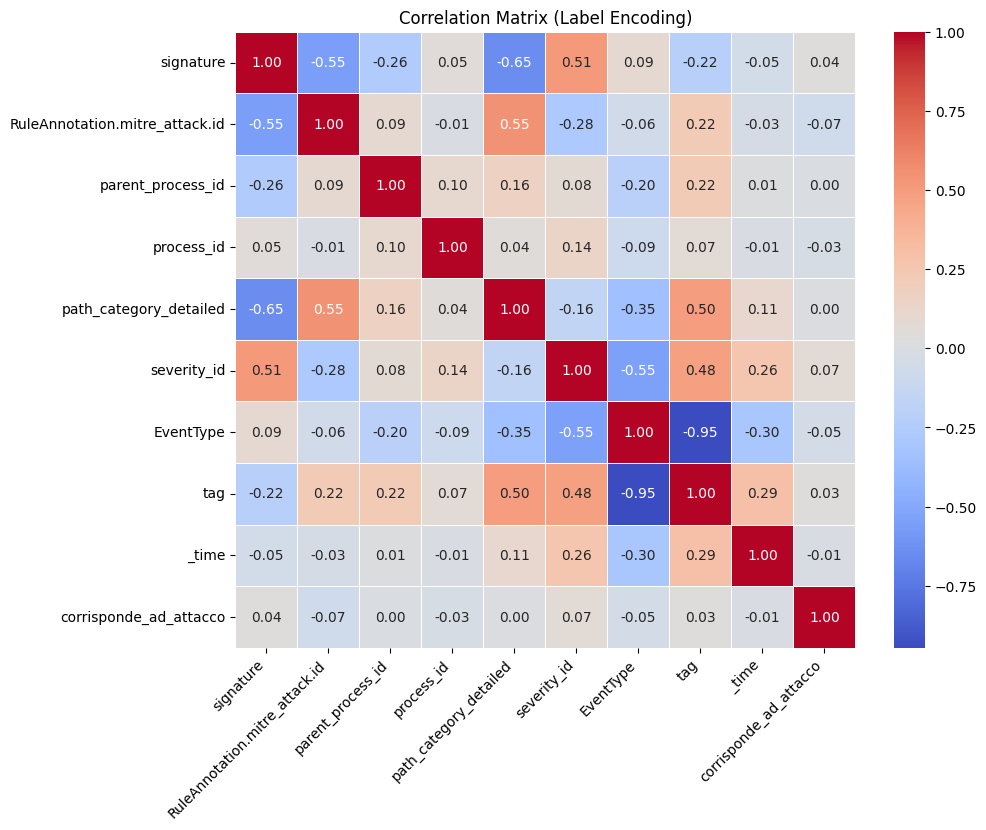

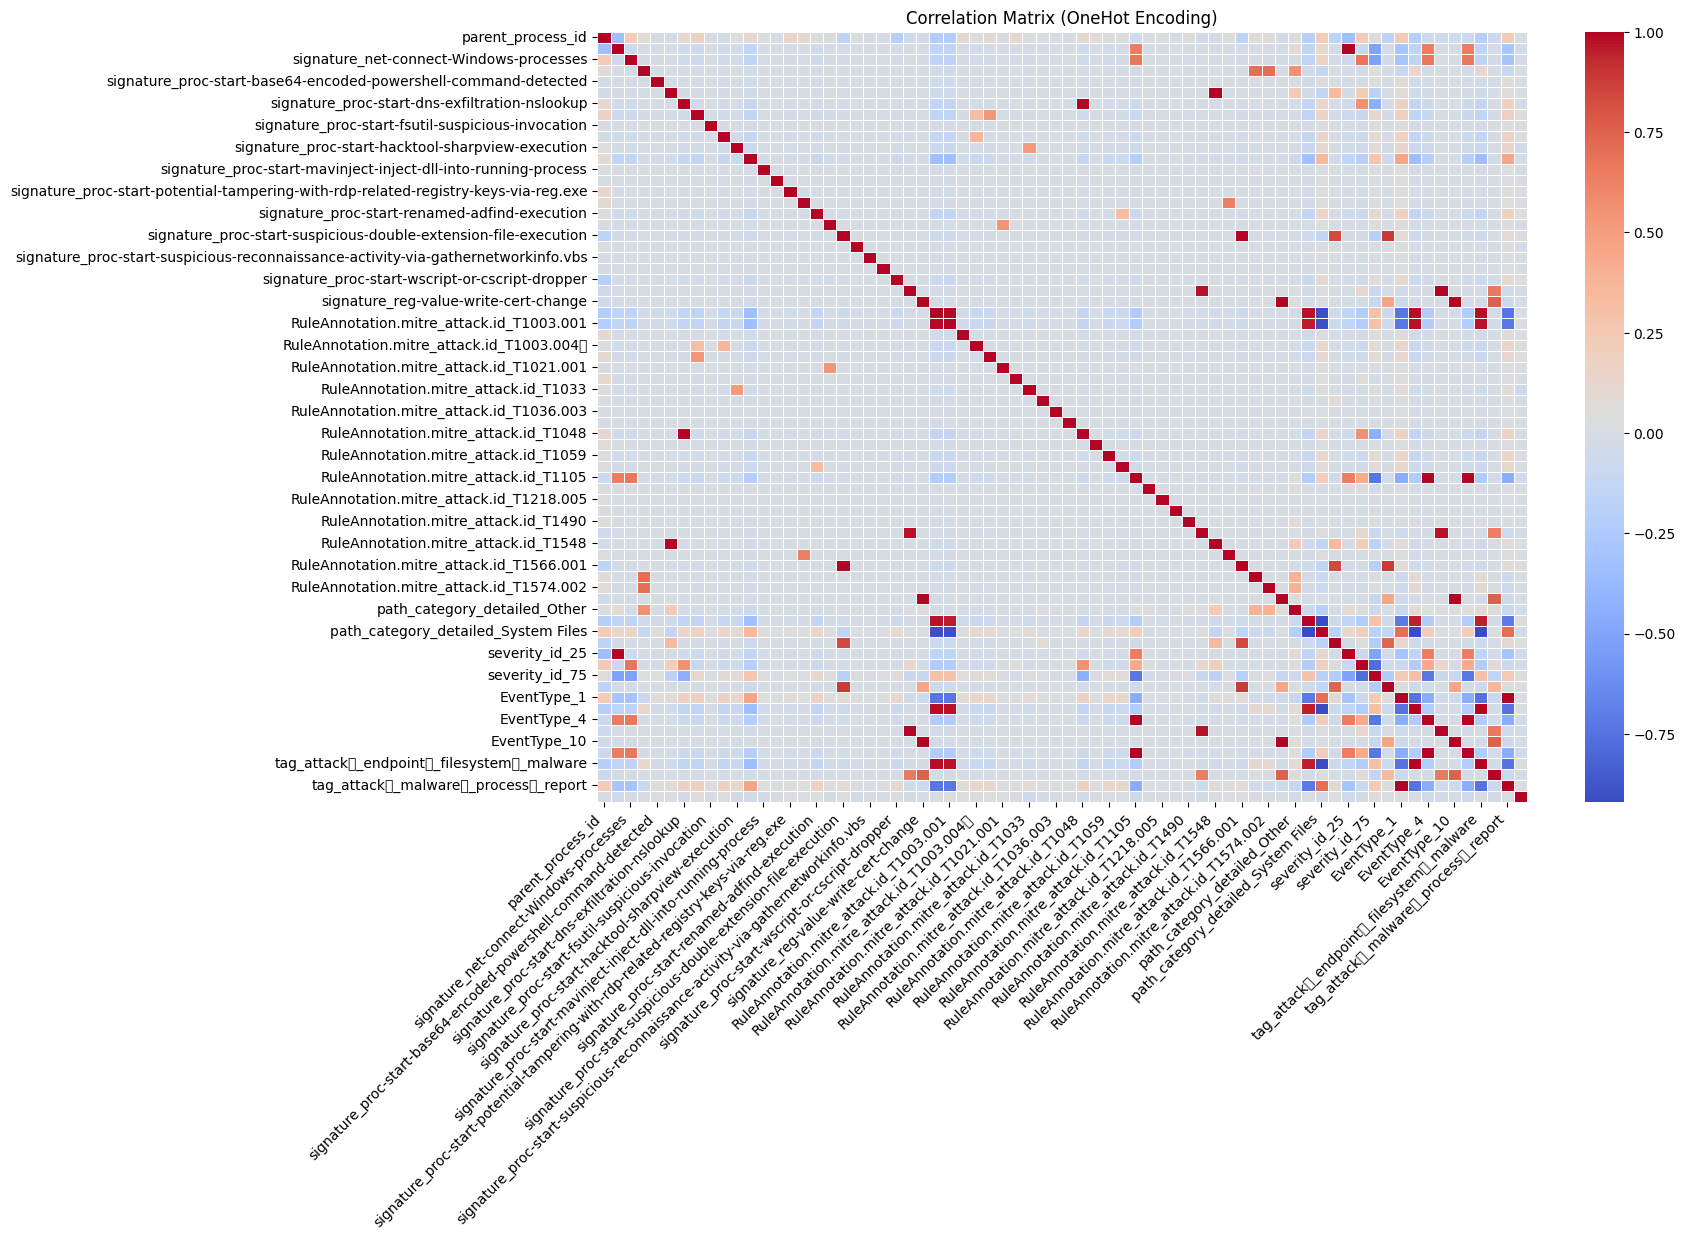

In [27]:
CorrelationMatrixPlots.plot_correlation_matrix(result_df_Le, 'Correlation Matrix (Label Encoding)')
CorrelationMatrixPlots.plot_correlation_matrix_big(result_df_OH, 'Correlation Matrix (OneHot Encoding)')

# ML

### OneHot

In [28]:
# Split data
X_train_OH, X_test_OH, y_train_OH, y_test_OH = PreprocessingTrainTestSplit.split_data(result_df_OH, "corrisponde_ad_attacco")

# Initial model training and evaluation
InitialTraining.train_and_evaluate_initial_models(X_train_OH, y_train_OH, X_test_OH, y_test_OH)

# Hyperparameter tuning
best_models_OH = HyperparameterTuning.tune_hyperparameters(X_train_OH, y_train_OH)

# Evaluate best models on test set
evaluator_OH = ModelEvaluator(best_models_OH)
evaluation_results_OH = evaluator_OH.evaluate_models(X_test_OH, y_test_OH)

# Train XGBoost model
AdvancedModels.train_xgboost(X_train_OH, y_train_OH, X_test_OH, y_test_OH)

# Train deep learning model
DeepLearningModel.train_deep_learning_model(X_train_OH, y_train_OH, X_test_OH, y_test_OH)


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       223
           1       0.96      0.98      0.97      2211

    accuracy                           0.94      2434
   macro avg       0.84      0.79      0.81      2434
weighted avg       0.94      0.94      0.94      2434


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.18      0.31       223
           1       0.92      1.00      0.96      2211

    accuracy                           0.92      2434
   macro avg       0.95      0.59      0.63      2434
weighted avg       0.93      0.92      0.90      2434


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.45      0.59       223
           1       0.95      0.99      0.97      2211

    accuracy                           0.94      2434
   macro avg       0.91  

<Sequential name=sequential, built=True>

### Label

In [29]:
# Split data
X_train_Le, X_test_Le, y_train_Le, y_test_Le = PreprocessingTrainTestSplit.split_data(result_df_Le, "corrisponde_ad_attacco")

# Initial model training and evaluation
InitialTraining.train_and_evaluate_initial_models(X_train_Le, y_train_Le, X_test_Le, y_test_Le)

# Hyperparameter tuning
best_models_Le = HyperparameterTuning.tune_hyperparameters(X_train_Le, y_train_Le)

# Evaluate best models on test set
evaluator_Le = ModelEvaluator(best_models_Le)
evaluation_results_Le = evaluator_Le.evaluate_models(X_test_Le, y_test_Le)

# Train XGBoost model
AdvancedModels.train_xgboost(X_train_Le, y_train_Le, X_test_Le, y_test_Le)

# Train deep learning model
DeepLearningModel.train_deep_learning_model(X_train_Le, y_train_Le, X_test_Le, y_test_Le)


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       223
           1       0.96      0.97      0.97      2211

    accuracy                           0.94      2434
   macro avg       0.83      0.80      0.81      2434
weighted avg       0.94      0.94      0.94      2434


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.18      0.30       223
           1       0.92      1.00      0.96      2211

    accuracy                           0.92      2434
   macro avg       0.96      0.59      0.63      2434
weighted avg       0.93      0.92      0.90      2434


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.50      0.64       223
           1       0.95      0.99      0.97      2211

    accuracy                           0.95      2434
   macro avg       0.91  

<Sequential name=sequential_1, built=True>

In [30]:
evaluator_OH.print_best_model('OneHot Encoder')
evaluator_Le.print_best_model('Label Encoder')


Dopo la codifica con OneHot Encoder il modello migliore è stato KNN con lo score di 0.9272

Dopo la codifica con Label Encoder il modello migliore è stato KNN con lo score di 0.9334
